# GeoTIFF → JSON (Jupyter)
Notebook simples para **ler um GeoTIFF (TIF)**, extrair **metadados**, calcular **estatísticas por banda (streaming)** e **salvar um JSON** com o resumo.

> Use este notebook localmente no seu Jupyter (Windows). Ele não depende de nenhum arquivo enviado aqui.


## Requisitos (rode apenas se precisar instalar)
No Windows/PowerShell você pode criar um venv e instalar:
```powershell
python -m venv .venv
.\.venv\Scripts\Activate.ps1
pip install rasterio numpy pyproj matplotlib
```

Se quiser instalar direto no Jupyter (Colab, etc.):
```python
# !pip install rasterio numpy pyproj matplotlib
```


In [ ]:
# Imports e funções utilitárias
import os, math, json, numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import xy as transform_xy
from pyproj import Transformer
import matplotlib.pyplot as plt

def robust_min_max(src, samples=8):
    vals = []
    for i, (_, w) in enumerate(src.block_windows(1)):
        arr = src.read(1, window=w, masked=True)
        if arr.size == 0:
            continue
        a = arr.compressed() if np.ma.isMaskedArray(arr) else arr.reshape(-1)
        if a.size:
            n = min(50000, a.size)
            idx = np.random.choice(a.size, n, replace=False)
            vals.append(a[idx])
        if i+1 >= samples:
            break
    if not vals:
        return None, None
    v = np.concatenate(vals)
    return float(np.nanmin(v)), float(np.nanmax(v))

def percentile_from_hist(bin_edges, hist, q):
    c = np.cumsum(hist).astype(float)
    if c[-1] == 0: return float('nan')
    target = q * c[-1]
    idx = np.searchsorted(c, target)
    idx = max(0, min(idx, len(bin_edges)-2))
    left = c[idx-1] if idx>0 else 0.0
    right = c[idx]
    frac = 0.0 if right==left else (target-left)/(right-left)
    return float(bin_edges[idx] + frac*(bin_edges[idx+1]-bin_edges[idx]))

def incremental_hist_stats(src, band=1, bins=512, value_range=None):
    if value_range is None:
        vmin, vmax = robust_min_max(src, samples=8)
        if vmin is None:
            return None
    else:
        vmin, vmax = value_range
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin==vmax:
        vmin, vmax = 0.0, 1.0

    hist = np.zeros(bins, dtype=np.float64)
    count = 0; mean = 0.0; M2 = 0.0; masked_count = 0

    for _, w in src.block_windows(band):
        arr = src.read(band, window=w, masked=True)
        if np.ma.isMaskedArray(arr) and arr.mask is not np.ma.nomask:
            masked_count += int(np.count_nonzero(arr.mask))
            data = arr.compressed()
        else:
            data = arr.reshape(-1)
        if data.size == 0: continue

        h, edges = np.histogram(data, bins=bins, range=(vmin, vmax))
        hist += h

        count_inc = data.size
        delta = data.mean() - mean
        total = count + count_inc
        mean += delta * (count_inc / max(1, total))
        M2 += data.var() * count_inc + (delta**2) * (count * count_inc / max(1, total))
        count = total

    var = M2 / max(1, (count-1))
    std = math.sqrt(var) if var >= 0 else float('nan')

    p25 = percentile_from_hist(edges, hist, 0.25)
    p50 = percentile_from_hist(edges, hist, 0.50)
    p75 = percentile_from_hist(edges, hist, 0.75)

    return {
        "min_est": float(vmin),
        "max_est": float(vmax),
        "mean_est": float(mean),
        "std_est": float(std),
        "count_valid": int(count),
        "count_masked": int(masked_count),
        "hist_bins": int(bins),
        "p25_est": float(p25),
        "median_est": float(p50),
        "p75_est": float(p75)
    }

def crs_to_epsg_str(crs):
    try:
        code = crs.to_epsg()
        if code:
            return f"EPSG:{code}"
    except Exception:
        pass
    return None

def dataset_bounds_wgs84(src):
    if src.crs is None:
        return None
    
    # quatro cantos em coordenadas do dataset
    H, W = src.height, src.width
    coords = [transform_xy(src.transform, r, c, offset='center') 
              for (r,c) in [(0,0),(0,W-1),(H-1,0),(H-1,W-1)]]
    xs = [c[0] for c in coords]; ys = [c[1] for c in coords]
    
    try:
        if src.crs.to_string() != "EPSG:4326":
            transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
            xs, ys = transformer.transform(xs, ys)
    except Exception:
        return None
    return [float(min(xs)), float(min(ys)), float(max(xs)), float(max(ys))]

# Configurações — Caminho dos arquivos TIF para criar metadados e caminho do arquivo JSON de saída
TIF_PATHS = [
    "outputs/tropical_tree_cover_data/10S_050W_F10m.tif",
    "outputs/tropical_tree_cover_data/10S_060W_F10m.tif",
    "outputs/tropical_tree_cover_data/20S_050W_F10m.tif",
    "outputs/tropical_tree_cover_data/20S_060W_F10m.tif"
]

OUT_JSON = None  # Se None, salva ao lado do TIF com sufixo .metadata.json

print("Entrada:", TIF_PATHS)
print("Saída JSON:", OUT_JSON or "(auto ao lado do TIF)")

In [9]:
# Abrir o TIF, coletar metadados e estatísticas
from pathlib import Path

for TIF_PATH in TIF_PATHS:
    tif_path = Path(TIF_PATH)
    assert tif_path.exists(), f"Arquivo não encontrado: {tif_path}"
    out_json = Path(OUT_JSON) if OUT_JSON else tif_path.with_suffix(".metadata.json")

    with rasterio.open(tif_path) as src:
        prof = src.profile.copy()
        tags = src.tags()
        tags_tiff = src.tags(ns='TIFF')
        
        try:
            colormap_tag = src.colormap(1) if src.count >= 1 else None
        except ValueError:
            colormap_tag = None

        info = {
            "file": str(tif_path),
            "driver": src.driver,
            "width": src.width,
            "height": src.height,
            "count_bands": src.count,
            "dtype": str(src.dtypes[0]) if src.count else None,
            "nodata": src.nodata,
            "crs_wkt": src.crs.wkt if src.crs else None,
            "crs_epsg": crs_to_epsg_str(src.crs) if src.crs else None,
            "transform": list(src.transform) if src.transform else None,
            "resolution": list(src.res) if src.res else None,
            "bounds_dataset_crs": list(src.bounds) if src.bounds else None,
            "bounds_wgs84": dataset_bounds_wgs84(src),
            "tiled": bool(prof.get("tiled", False)),
            "blockxsize": int(prof.get("blockxsize", 0)) if prof.get("tiled", False) else None,
            "blockysize": int(prof.get("blockysize", 0)) if prof.get("tiled", False) else None,
            "compress": prof.get("compress"),
            "interleave": prof.get("interleave"),
            "colorinterp": [str(ci) for ci in src.colorinterp] if src.count else None,
            "has_colormap_band1": bool(colormap_tag) if src.count >= 1 else False,
            "geo_tags": tags,
            "tiff_tags": tags_tiff,
        }

        stats = {}
        for b in range(1, src.count+1):
            try:
                st = incremental_hist_stats(src, band=b, bins=512, value_range=None)
            except Exception as e:
                st = {"error": str(e)}
            stats[f"band_{b}"] = st
        info["stats"] = stats
        info["is_probably_cog"] = bool(info["tiled"]) and info["compress"] is not None

    # Salvar JSON
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(info, f, ensure_ascii=False, indent=2)

    print("JSON salvo em:", out_json)

JSON salvo em: outputs_batch4\20S_050W_F10m.metadata.json
JSON salvo em: outputs_batch4\20S_060W_F10m.metadata.json


Preview do raster: tropical_tree_cover_data/10S_050W_F10m.tif


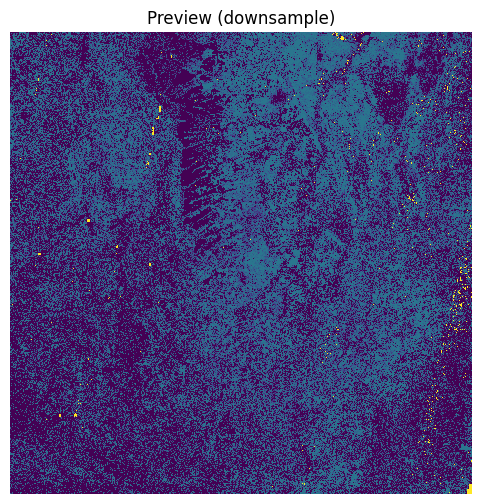

Preview do raster: tropical_tree_cover_data/10S_060W_F10m.tif


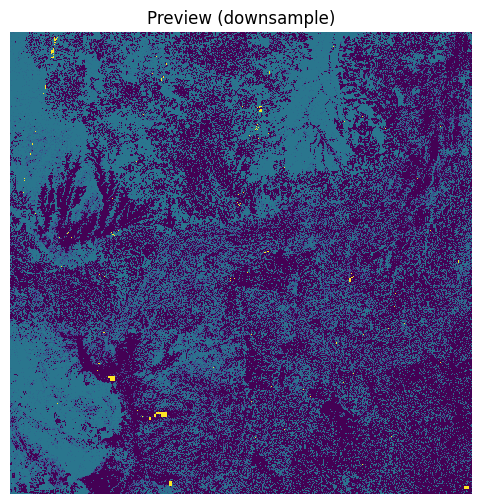

Preview do raster: tropical_tree_cover_data/20S_050W_F10m.tif


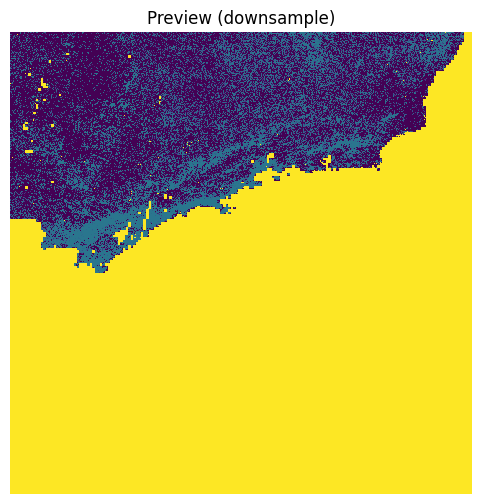

Preview do raster: tropical_tree_cover_data/20S_060W_F10m.tif


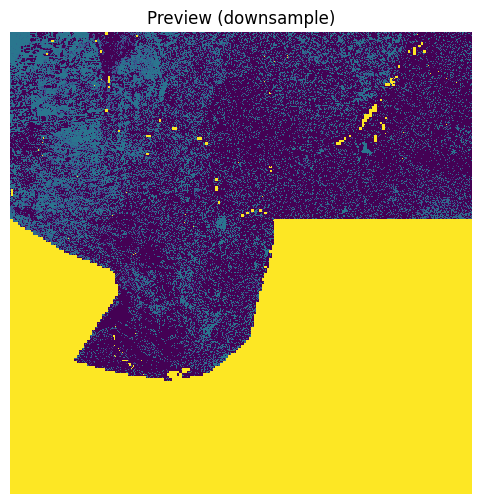

In [4]:
# Visualizações rápidas (opcional)
# 1) Preview do raster (downsample para caber na memória)
for TIF_PATH in TIF_PATHS:
    print("Preview do raster:", TIF_PATH)
    with rasterio.open(TIF_PATH) as src:
        h, w = src.height, src.width
        # limita o preview a no máx. 3000 px em cada dimensão
        scale = max(1, max(h, w) // 3000)
        out_h = max(1, h // scale)
        out_w = max(1, w // scale)
        preview = src.read(1, out_shape=(out_h, out_w), resampling=Resampling.nearest)

    plt.figure(figsize=(6,6))
    plt.imshow(preview, interpolation='nearest')
    plt.title("Preview (downsample)")
    plt.axis("off")
    plt.show()